# CDL Quantum 2021 - Cohort Project

## Week 1 Challenge: Simulating Quantum Advantage with Trapped Ions

### Team 3: Ziwei Qiu, Oleg Fonarev, Estelle Inack, Yuval Sanders, Alex Khan¶

### Additional Challenges

3. Run your quantum circuits on a trapped ion quantum computer

### Introduction 

The purpose of this is to show an actual implementation of the Google Supremacy experiment on an actual IonTrap.

This code performs Task 1 on IonQ using Amazon Braket. We first create the random circuit using create_circ()
and then run it on both the classical LocalSimulator() and on IonQ's IonTrap with using all 11 qubits. 

The first section of this code will include instructions to set up the Amazon Braket Environment,
then some code to determine and designate the localSimulator() and IonQ devices.

Then we will create a random circuit using the same method as used in the Google Supremacy experiments.
We convert the R Unitary and M Unitary to IonQ gate operations that are available in Amazon Braket.

Then we run the same circuit using 11 qubits and gate depth of 20 through the LocalSimulator() and IonQ Devices.



### Setup Amazon Braket API

1. Create an amazon braket account at https://aws.amazon.com/braket/
2. Create user credentials and retrieve your aws_access_key_id and aws_secret_access_key
3. Install the following

In [ ]:
!pip install dwave-ocean-sdk
!pip install boto3
!pip install amazon-braket-sdk

4. In your c:\users\[your user name] directory create a folder called .aws
5. Place a config file in the .aws folder (file name config with no extension) with the following text

In [ ]:
[default]
region = us-east-1
aws_access_key_id=[Key from AWS]
aws_secret_access_key=[Key from AWS]

This ends the setup process

## Execute Code starting Here

During the Braket setup in 1. you will create a bucket that is used to store the results from the Braket devices. 
Enter the S3 bucket you created during onboarding in the code below along with a folder name

In [2]:
my_bucket = "amazon-braket-[bucket name]" # the name of the bucket
my_prefix = "[folder name]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [1]:
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
rng = np.random

In [4]:
device_list=AwsDevice.get_devices(statuses=['ONLINE'])
for i in device_list:
    print(i)

Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1)
Device('name': Aspen-9, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-9)
Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)
Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
Device('name': dm1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/dm1)


In [5]:
device_ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
device_local = LocalSimulator()

In [6]:
# Gates for LocalSimulator
supported_gates = device_local.properties.action['braket.ir.jaqcd.program'].supportedOperations
print(supported_gates)

['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CY', 'CZ', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


In [7]:
# Gates for IonQ
supported_gates = device_ionq.properties.action['braket.ir.jaqcd.program'].supportedOperations
print(supported_gates)

['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


In [9]:
price_per_shot=device_ionq.properties.service.deviceCost.price
unit=device_ionq.properties.service.deviceCost.unit
num_shots=1000
cost_per_task=0.3
print('device cost per ',unit,': $', price_per_shot)
print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))

device cost per  shot : $ 0.01
total cost for 1000 shots is $10.30


### Create gates that represent the unitaries in Task 1

read about Amazon Braket
https://docs.aws.amazon.com/braket/latest/developerguide/braket-developer-guide.pdf

    
read about ionQ
https://ionq.com/best-practices/
    

Converting the R unitary to gate operations for Amazon Braket circuit and IonQ


$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U3(\theta, \phi, \lambda) =
    \begin{pmatrix}
        \cos(\th)          & -e^{i\lambda}\sin(\th) \\
        e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

$U3(θ,ϕ,λ)=RZ(ϕ)RX(−π/2)RZ(θ)RX(π/2)RZ(λ)$

Since we are only using two angles and 

$\lambda = -\phi$

$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U_r(\theta, \phi) =
    \begin{pmatrix}
        \cos(\th)          & -e^{-i\phi}\sin(\th) \\
        e^{i\phi}\sin(\th) & \cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

$U_r(\theta, \phi) =
    RZ(\phi) RX(-\pi/2) RZ(\theta) RX(\pi/2) RZ(-\phi)$

In [12]:
# Single qubit gate  U_r(Theta, phi)  
def u_r (circ, q, Theta, phi):

    circ.rz(q, phi).rx(q, -np.pi/2).rz(q, Theta).rx(q, np.pi/2).rz(q, -phi)
    
    return(circ)

The M gate is defined as the xx gate for IonQ

$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U_m(\theta)=R_{XX}(\theta) = exp(-i \th X{\otimes}X) =
    \begin{pmatrix}
        \cos(\th)   & 0           & 0           & -i\sin(\th) \\
        0           & \cos(\th)   & -i\sin(\th) & 0 \\
        0           & -i\sin(\th) & \cos(\th)   & 0 \\
        -i\sin(\th) & 0           & 0           & \cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

In [14]:
# Two qubit gate
def u_m (circ, q, r, Theta ):
    
    circ.xx(q,r,rng.random()*np.pi )
    
    return(circ)
    

### Function to create a random circuit

In [15]:
def create_circ(N, depth, print_circ=False):
    circ=Circuit()
    alternate=False
    for i in range (depth):
        
        # Ur gate added to each qubit
        for j in range(N):
            circ=u_r(circ, j, rng.random()*2*np.pi, rng.random()*2*np.pi)
            
        # Now xx gate alternate order
        idx_first = i % 2
        
        for j in range(idx_first,N-1,2):
            circ=u_m(circ, j, j+1, rng.random()*2*np.pi)
                
    if print_circ==True:
        print(circ)

    return(circ)

### Function to Execute circuit on an Amazon Device

In [16]:
def run_circ(circ, device, shots, s3_folder=''):

    if device.name=='StateVectorSimulator':
        result = device.run(circ, shots=shots).result()
    else:
        result = device.run(circ, s3_folder, shots=shots).result()
    
    counts = result.measurement_counts
    return(counts)

In [17]:
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return(decimal)   

In [18]:
# Circuit Parameters
N=11
depth=20

# Number of times same random circuit is measured
shots=1000

# Number of times the experiment is repeated for 2-D and 3-D plots. This is not used on IonQ
n = 50

circ=create_circ(N, depth)

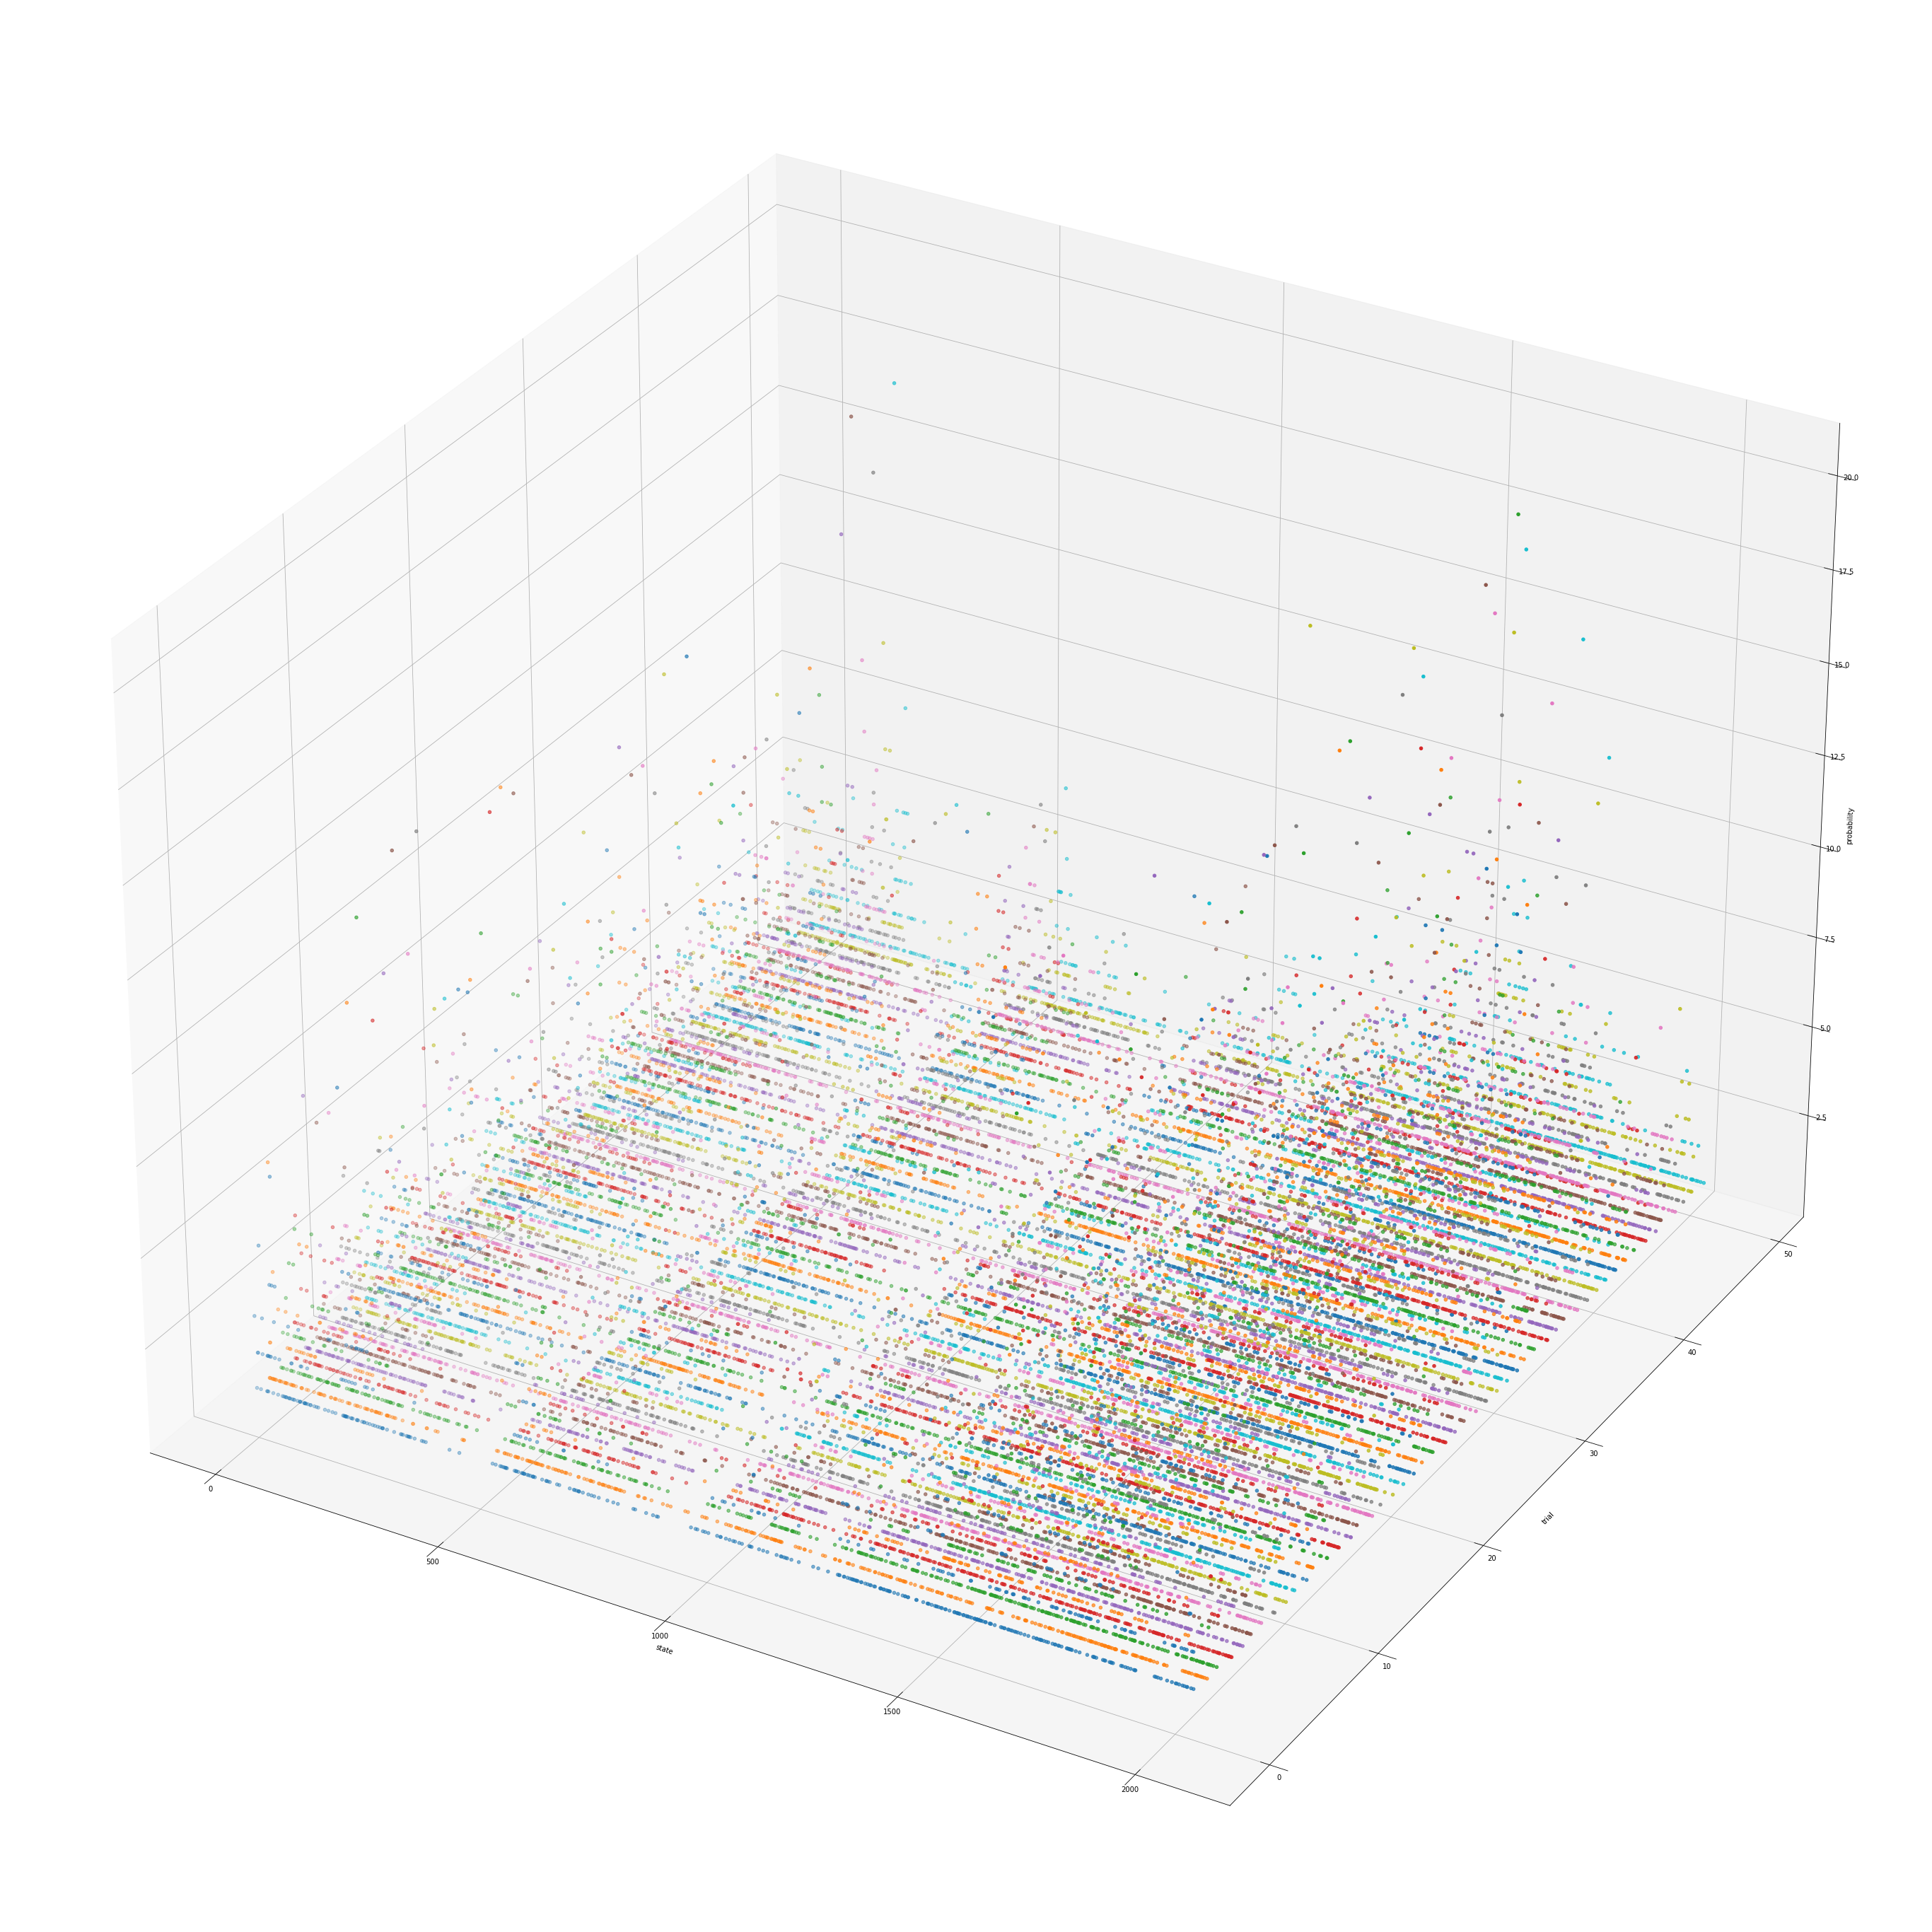

In [20]:
# plot multiple trial results in 3-D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(n):
    counts=run_circ(circ, device_local, shots)
    x_list=[]
    y_list=[]
    for j in counts.keys():
        x_list.append(binaryToDecimal(int(j)))
        y_list.append(i)
        
    xs = x_list
    ys = y_list
    zs = list(counts.values())
    ax.scatter(xs, ys, zs, marker="o")
    
ax.set_xlabel('state')
ax.set_ylabel('trial')
ax.set_zlabel('probability')
plt.rcParams["figure.figsize"] = (50,50)
plt.show()

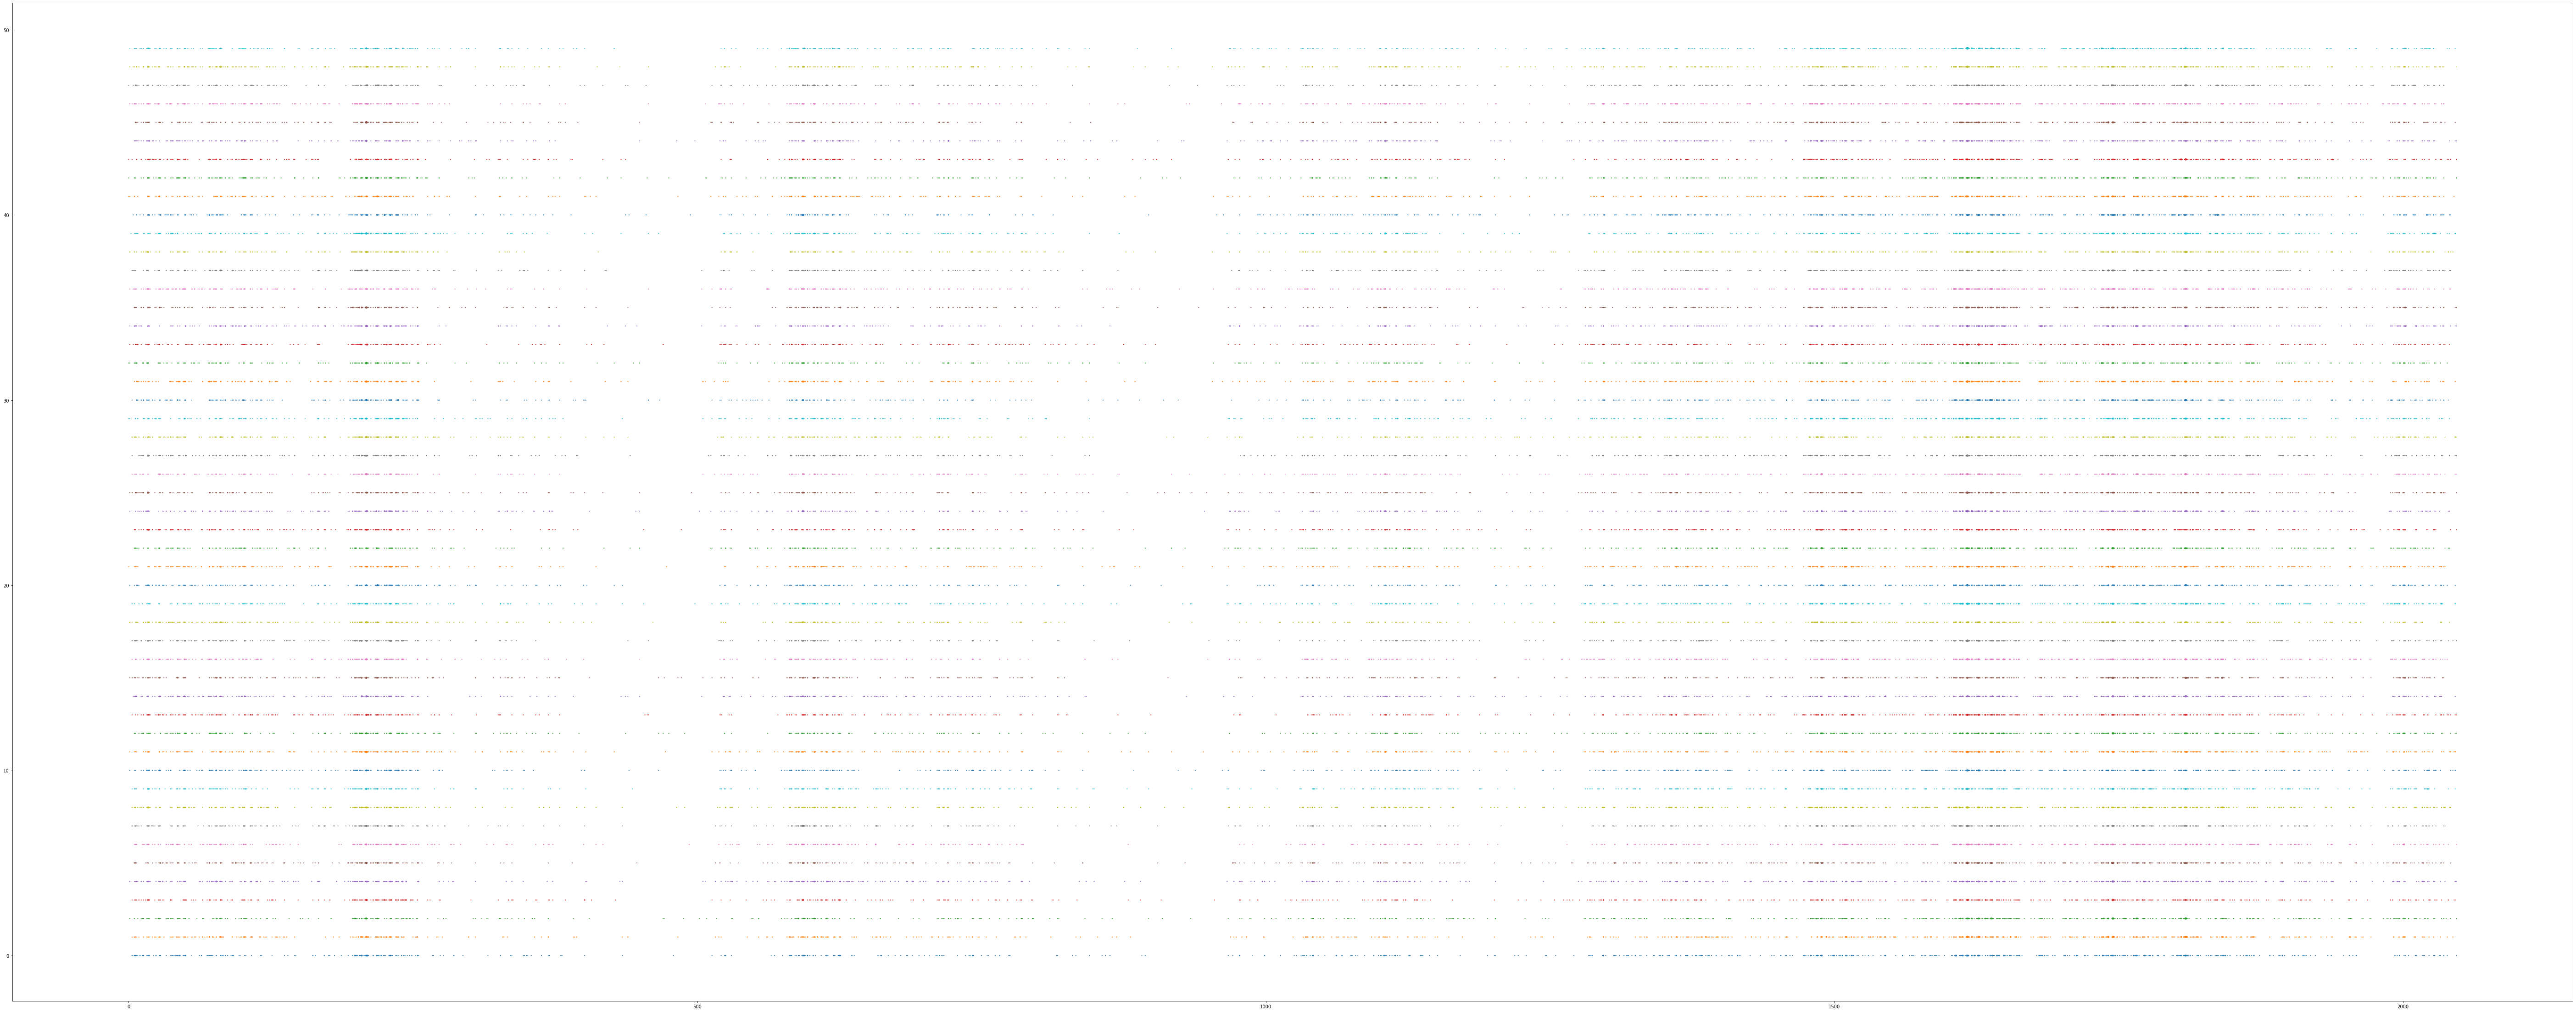

In [21]:
# Plot multiple trial results in 2-D
for i in range (n):
    counts=run_circ(circ, device_local, shots)
#print(counts)
#plt.axis('off')
    plt.rcParams["figure.figsize"] = (100,40)
    #y_list=np.zeros(len(counts.keys()))
    x_list=[]
    y_list=[]
    for j in counts.keys():
        x_list.append(binaryToDecimal(int(j)))
        y_list.append(i)
    plt.scatter(x_list, y_list, list(counts.values()))
plt.show()
#plt.scatter(counts.keys(),list(counts.values()))

In [ ]:
'STOP here if you do not want to pay for IonQ cost'

In [ ]:
# Now run on IonQ

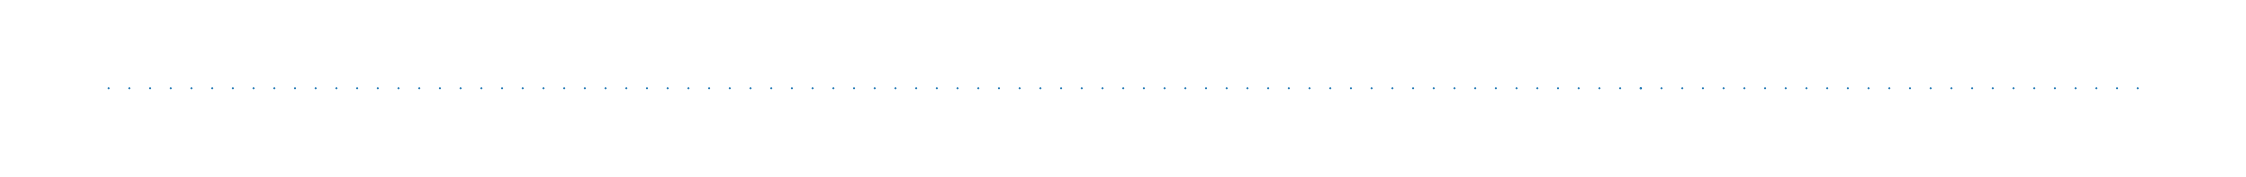

In [20]:
# run on ionQ device, get probability distribution using one random circuit
# uncomment below if wanting to do more than 10 shots. Note 10,000 shots on IonQ=$100
shots=10

counts=run_circ(device_ionq, N, depth, shots, False, s3_folder)
plt.axis('off')
plt.rcParams["figure.figsize"] = (40,3)
y_list=np.zeros(len(counts.keys()))
plt.scatter(counts.keys(), y_list, list(counts.values()))

Note the above result was run using 1000 shots. However a very low speckle pattern was detected likely due to 
1. Decoherence in the actual hardware
2. Low sampling compared to the 2^11 possible states


A magnified view of above pattern reveals some speckles. 
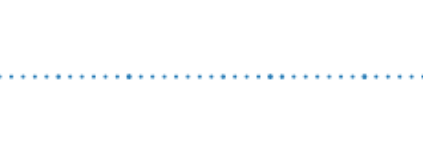